In [2]:
rm(list=ls())
library(refund);
library(ggplot2)
library(dplyr); 
library(dplyr); 
library(reshape2); 
library(fda);
library(fdaACF)
set.seed(100)

# Table of contents: tbd

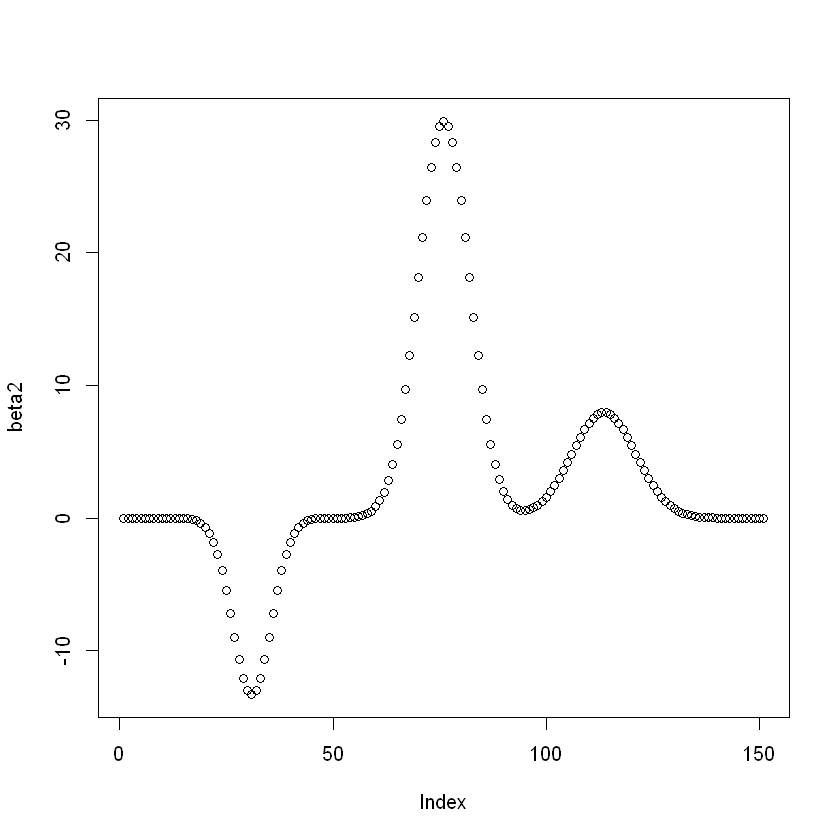

In [3]:
# set up "global" variables
n_obs = 60
n_var = 150 #number of vars
test = seq(1,20,1)
grid = seq(0, 1, length = n_var+1)

# set up functions here!
#smooth
f1 <- 2*sin(0.5*pi*grid) + 4*sin(1.5*pi*grid) + 5*sin(2.5*pi*grid)
#bumpy
f2 <- 1.5*exp(-0.5*(grid-0.3)^2/0.02^2) -
  4*exp(-0.5*(grid-0.45)^2/0.015^2) +
  8*exp(-0.5*(grid-0.6)^2/0.02^2) -
  exp(-0.5*(grid-0.8)^2/0.03^2)
beta1 = sin(grid * 2 * pi)
beta2 = -dnorm(grid, mean=.2, sd=.03) +3*dnorm(grid, mean=.5, sd=.04)+dnorm(grid, mean=.75, sd=.05)
fun_1 = 2*sin(grid*0.5*pi) +4*sin(grid*2.5*pi) + 5*sin(grid*2.5*pi)

nharm = 4 #number of fpc
plot(beta2)


In [4]:
data_generation <-function(fun){
    var1 = 1
    var2 = 2
    var3 = 0.2

    # X <- matrix(0, nrow=n_obs, ncol=length(grid))
    # for(i2 in 1:n_obs){
    #     X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    #     X[i2,]=X[i2,]+runif(1, 0, var2)
    #     X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        
    #     for(j2 in 1:10){
    #         e =rnorm(2, 0, var1/j2^(2))
    #         X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
    #         X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
    #     }
    # }
    # return(X)
    # }
    # This is a "more clear" setup

    X <- matrix(0, nrow=n_obs, ncol=length(grid))
    for(i2 in 1:n_obs){
        X[i2,]=X[i2,]+rnorm(length(grid), 2, var1)
        X[i2,]=X[i2,]+runif(1, 0, var2)
        X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        X[i2,]=X[i2,]*fun

        for(j2 in 1:5){
           e =abs(rnorm(2, 0, var1/j2^(2)))
           X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
           X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
        }
        
    }
    return(X)
}


[1] "done"

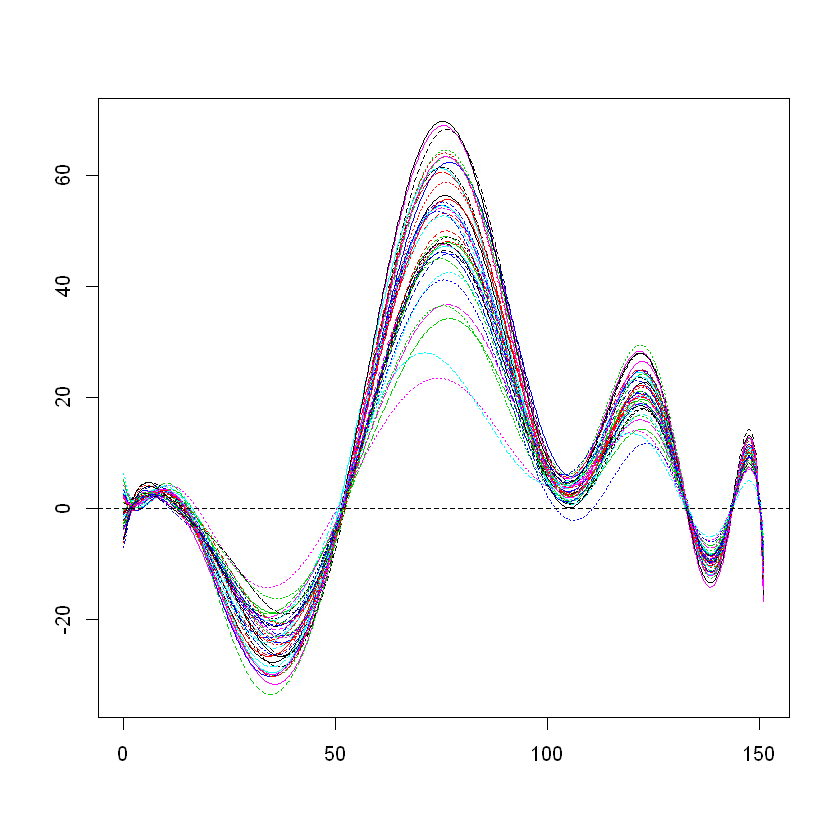

In [5]:
X = data_generation(beta2)
Y = X %*% (beta1/n_var) + rnorm(n_obs, 0, 0.125) 
Y = as.numeric(Y)
final_X = t(X)
X_train = final_X[,-test]
Y_train = Y[-test]
X_test = final_X[,test]
Y_test = Y[test]


smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 12, 7)
#harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd = smooth_basis_test$fd


# todo:use to choose appropriate level of explained variance

plot(smooth_basis_train_fd, ylab="", xlab="",col="gray")


[1] 0.3613107


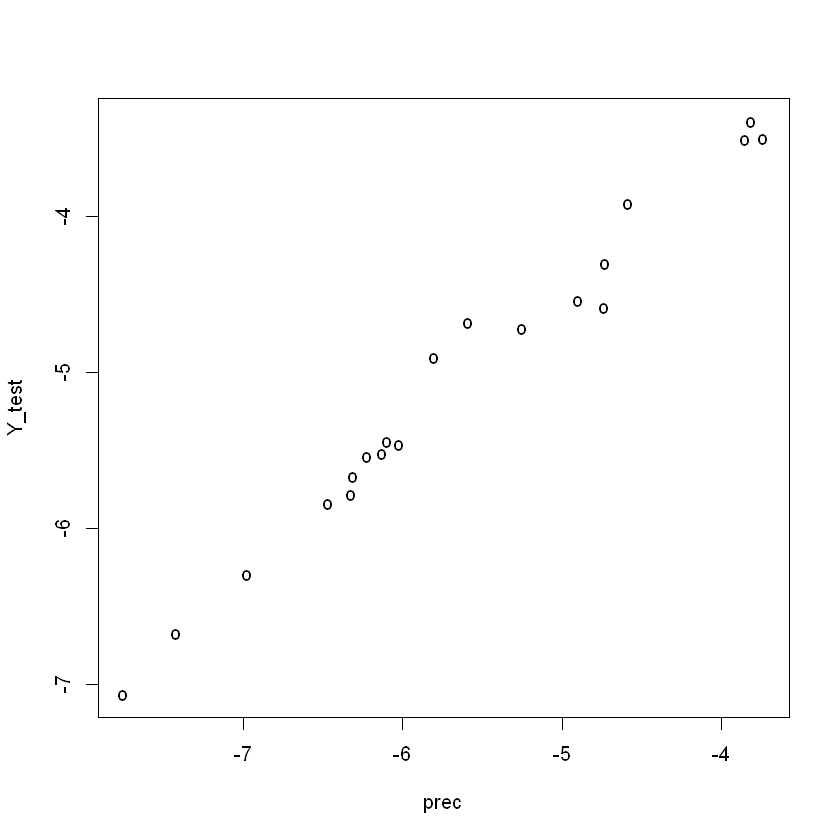

In [9]:
xfdlist = list( smooth_basis=smooth_basis_train_fd)
betabasis1 <- create.constant.basis(c(0, (n_obs-length(test))))
#betabasis_test <- create.constant.basis(c(0, length(test)))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)
betafdPar2  <- fdPar(betafd2)
betalist <- list(smooth_basis_fd=betafdPar2)

f_regress <- fRegress(y = Y_train, xfdlist, betalist, y2cMap = smooth_basis_train$y2cMap)
# also possible to use formula interface:
#f_regress2 <- fRegress(Y_train ~ smooth_basis_train_fd)
prec <- predict.fRegress(object = f_regress, 
                newdata = list(data = smooth_basis_test_fd))

# #  plot the data and the fit
#plot(f_regress$betaestlist[[2]])
# add true function plot
MSE_test <- mean((Y_test-prec)^2)
print(MSE_test)
plot(prec, Y_test, type="p", pch="o")




In [ ]:
# construct standart errors!
# negative stderr???
res = c((Y_train - predict(f_regress))^2)

SigmaE = diag(res, 40) 
y2cMap = smooth_basis_train$y2cMap
std_err = fRegress.stderr(f_regress, y2cMap, SigmaE)
std_err$betastderrlist


[[1]]
$coefs
                 [,1]
bspl7.1   0.030093893
bspl7.2   0.023004042
bspl7.3   0.010815430
bspl7.4   0.016398411
bspl7.5  -0.006907052
bspl7.6   0.020259816
bspl7.7  -0.011667603
bspl7.8   0.025458080
bspl7.9  -0.015657910
bspl7.10  0.042557029
bspl7.11 -0.008425366
bspl7.12  0.069125696

$basis
$call
basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params, 
    dropind = dropind, quadvals = quadvals, values = values, 
    basisvalues = basisvalues)

$type
[1] "bspline"

$rangeval
[1]   0 151

$nbasis
[1] 12

$params
[1]  25.16667  50.33333  75.50000 100.66667 125.83333

$dropind
NULL

$quadvals
NULL

$values
list()

$basisvalues
list()

$names
 [1] "bspl7.1"  "bspl7.2"  "bspl7.3"  "bspl7.4"  "bspl7.5"  "bspl7.6" 
 [7] "bspl7.7"  "bspl7.8"  "bspl7.9"  "bspl7.10" "bspl7.11" "bspl7.12"

attr(,"class")
[1] "basisfd"

$fdnames
$fdnames$time
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  2

## FPCR

In [65]:
smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 20, 5)
#harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd_2 = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd_2 = smooth_basis_test$fd


simulated_pcaObj_train2 = pca.fd(smooth_basis_train_fd_2, nharm = nharm,  centerfns = FALSE)
simulated_pcaObj_test2 = pca.fd(smooth_basis_test_fd_2, nharm = nharm, centerfns = FALSE)

#simulated_pcaObj_train$varprop 

data = simulated_pcaObj_train2$scores
f_regress_pca <- lm(Y_train ~ data)
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs

betafd = pca_coeffs[2,1]*simulated_pcaObj_train2$harmonics[1] +
        pca_coeffs[3,1]*simulated_pcaObj_train2$harmonics[2] + 
        pca_coeffs[4,1]*simulated_pcaObj_train2$harmonics[3]+ 
        pca_coeffs[5,1]*simulated_pcaObj_train2$harmonics[4]


coefvar = pca_coeffs[,2]**2

betavar = (pca_coeffs[2] * simulated_pcaObj_train2$harmonics[1])**2 +
          (pca_coeffs[3] * simulated_pcaObj_train2$harmonics[2])**2 +
          (pca_coeffs[4] * simulated_pcaObj_train2$harmonics[3])**2 + 
          (pca_coeffs[5] * simulated_pcaObj_train2$harmonics[4])**2

        #   This all has to become flexible! S.t we can choose the desired components that explain a
        #   certain amount of the variance and then this will become dynamic


#plot(betafd)
#lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
#lines(betafd-2*sqrt(betavar), lty=2, lwd=1)

########################
# JAKOB HELP US!!! / See WA Groupchat for possible solution!
########################
data = smooth.basis(y = X_test, fdParobj = simulated_pcaObj_train2$harmonics)
#data = simulated_pcaObj_test2$scores
a = as.matrix(data$fd$coefs)
rownames(a) = c()

prec_pca <- predict.lm(object = f_regress_pca, data.frame(data = a))
print()
MSE_test <- mean((Y_test-prec_pca)^2)
print(MSE_test)
#plot(prec_pca, Y_test, type="p", pch="o")


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.2662158958,0.2034448831,1.3085406,1.992179e-01
data1,-0.0175556906,0.0006133752,-28.6214540,7.151507e-26
data2,0.0002236297,0.0019094740,0.1171159,9.074377e-01
data3,0.0234927580,0.0028055702,8.3736127,7.094649e-10
data4,-0.0147251459,0.0033633614,-4.3781040,1.032140e-04


ERROR: Error in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$xlevels): ungültiger Typ (list) für die Variable 'data'


In [64]:
a = as.matrix(data$fd$coefs)
rownames(a) = c()
a

-3.2763779,-4.7850397,-4.8896955,-1.9382157,-6.775994,-1.6283885,-5.4968229,-4.0762293,-3.0485426,-4.3009595,-2.58400797,-0.47352798,-0.09435152,0.3428459,-0.7589338,-4.67965874,-3.5331508,-5.2379670,-4.5053745,-5.227459
7.0707169,9.6036070,9.8701864,5.6283791,15.451235,5.9580371,10.4642137,8.4473603,7.4529333,8.5263797,5.78265843,5.07704574,2.28481354,5.6786972,3.6213250,7.61613448,6.6534932,10.4194637,11.9171275,13.311482
-7.1477051,-11.5823221,-11.0731248,-4.5047319,-17.285309,-3.9845462,-12.1032640,-9.1220935,-6.8054073,-9.7398012,-5.58143374,-2.57856379,-0.51309266,-1.5753162,-2.3290184,-10.01107842,-7.5836157,-11.5255588,-12.0209809,-14.128188
11.4417637,16.1932507,16.7202611,7.9642562,24.650685,8.6082286,16.8549456,15.0944761,11.1811372,15.7774583,7.88107252,6.12148050,2.19476126,5.8141854,5.0954377,12.66194366,10.8463707,18.2637457,20.1993078,22.238257
-2.9953457,-10.9906595,-8.6111354,-0.7570950,-16.467373,0.9628067,-8.3021662,-7.8719798,-2.0917298,-9.9907120,-1.89099904,0.13860192,3.42044743,1.8347111,-1.7668387,-7.07395251,-4.1470034,-9.3387136,-12.3012610,-16.154654
-78.1007102,-65.1655607,-68.6635405,-47.9932582,-72.089137,-67.1852367,-57.9094262,-52.8959178,-60.7456032,-51.7222647,-50.46395478,-50.02168535,-70.65251590,-56.3343680,-39.2270016,-61.62044372,-69.6242166,-63.0071463,-63.2560771,-53.295910
25.1526718,15.7114206,26.4652003,16.9305847,16.774407,19.7992266,26.4907026,17.3912277,23.9478121,11.1614079,17.82238101,18.92207114,16.56232608,21.1209269,8.5775027,21.40466231,24.3321671,22.2692960,18.2383589,14.440809
0.3035839,7.7957929,-6.8112046,-2.8218819,12.013980,6.2282949,-7.4074920,-0.1858731,-2.7084338,11.1622906,-4.15201813,-6.67612513,4.54853695,-10.5030503,4.2366653,-3.76900061,-3.2289338,1.6190392,4.5608391,4.563661
-21.5850919,-34.2894314,-7.2456381,-12.7638589,-47.205095,-32.0991258,-7.3772918,-12.5022934,-15.2125681,-31.9869101,-10.50097995,-7.26035116,-24.57218846,-2.3227083,-17.8973011,-12.12291014,-13.0070484,-18.8170254,-29.8735809,-29.658643
96.1289265,109.8357208,64.5396893,63.3429080,136.010432,101.3354124,58.0776876,59.5887457,71.7104682,84.3186619,59.86260980,48.40143589,76.97322491,36.2937705,50.4004011,70.82516528,73.8376400,87.5134365,95.1991729,93.435779
120.8804246,123.1911379,106.3607849,88.0673567,105.024076,113.5727651,95.7294907,164.5442351,71.5259225,108.9027305,63.22082252,60.71980843,114.58213322,85.7459946,87.2183753,103.23600862,144.0704519,97.4117378,82.9825866,82.248658


## Sandbox for exploring more stuff

[1] "done"

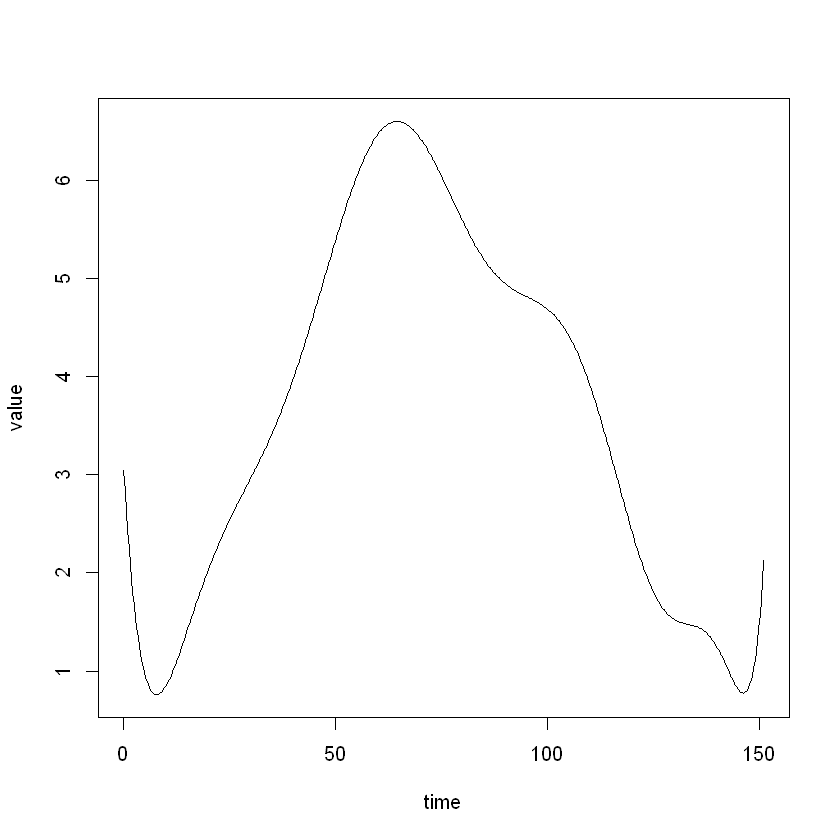

[1] "done"

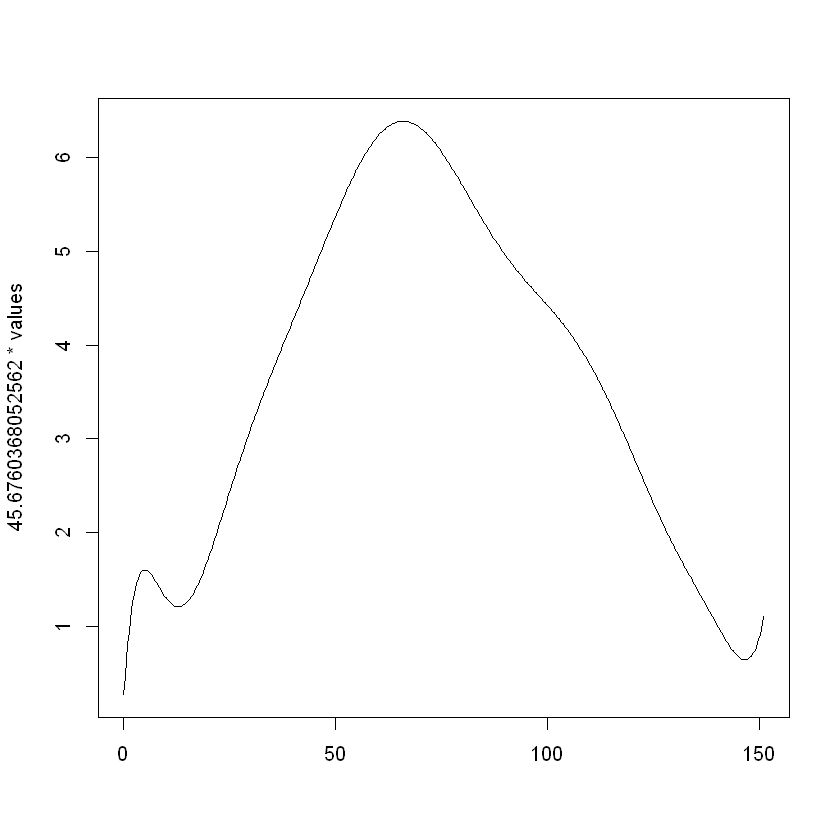

In [35]:

fd_rec = reconstruct_fd_from_PCA(simulated_pcaObj_test, simulated_pcaObj_test$scores[1,], centerfns= FALSE)
plot(smooth_basis_test_fd[1])
plot(fd_rec, add = TRUE, col = "red")

In [32]:
# implementation of refund package
fit <- fpcr(Y_train, xfuncs = X_train ,nbasis=seq(20,40,5), ncomp = seq(10,20,5), store.cv = TRUE)
refund_coeffs = fit$coefficient[2:5]
fit$cv.table


nbasis: 20 
nbasis: 25 
nbasis: 30 
nbasis: 35 
nbasis: 40 
nbasis: 20 


,ncomp 10,ncomp 15,ncomp 20
nbasis= 20,6.880185,6.907370,7.843633
nbasis= 25,6.886436,6.900469,6.895957
nbasis= 30,6.902366,6.903775,6.901408
nbasis= 35,6.907136,6.910686,6.907625
nbasis= 40,6.887959,6.903498,6.899217


In [33]:
fit <- fpcr(Y_train, xfuncs = X_train ,nbasis = 25, ncomp = 5, nfold = 10)
names(fit)

nbasis: 25 


[1] "coefficients"      "residuals"         "fitted.values"    
 [4] "family"            "linear.predictors" "deviance"         
 [7] "null.deviance"     "iter"              "weights"          
[10] "working.weights"   "prior.weights"     "df.null"          
[13] "y"                 "converged"         "boundary"         
[16] "rV"                "db.drho"           "dw.drho"          
[19] "ldetS1"            "reml.scale"        "aic"              
[22] "rank"              "sp"                "gcv.ubre"         
[25] "outer.info"        "scale"             "scale.estimated"  
[28] "control"           "method"            "Vc"               
[31] "edf2"              "Vp"                "hat"              
[34] "Ve"                "edf"               "edf1"             
[37] "R"                 "nsdf"              "sig2"             
[40] "smooth"            "paraPen"           "formula"          
[43] "var.summary"       "cmX"               "model"            
[46] "terms"             "pred.formula"      "pterms"           
[49] "assign"            "xlevels"           "offset"           
[52] "df.residual"       "min.edf"           "optimizer"        
[55] "call"              "se"                "argvals"          
[58] "undecor.coef"      "fhat"              "nbasis"           
[61] "ncomp"

In [130]:
#manually calculate the predictions
a = 0.037941820
matrix(simulated_pcaObj_test$scores, ncol = 4) %*% pca_coeffs[2:5,1] + a


0.5152955248
0.8059169441
-0.1951727337
-0.4793935427
-0.6737135929
0.2201111372
-0.2009622298
0.4423741530
-0.8551098239
-1.2226525314
0.7641808338


-0.072770670
-0.055810246
-0.194771996
-0.224814348
-0.126862251
-0.082121220
-0.109502220
-0.133209246
-0.151457644
-0.234929107
-0.078711375


## Simulation Study

spend like 2 min on it so far... copied out of some of my older simulations

In [16]:
rm(list=ls())

data(gasoline)
octane <- (gasoline$octane)
NIR    <- as.matrix(gasoline$NIR)
test = seq(1,20,1)


# set up "global" variables
set.seed(100)
n_obs = 60
n_var = 400
grid = seq(0, 1, length = n_var+1)
#smooth
f1 <- 2*sin(0.5*pi*grid) + 4*sin(1.5*pi*grid) + 5*sin(2.5*pi*grid)
#bumpy
f2 <- 1.5*exp(-0.5*(grid-0.3)^2/0.02^2) -
  4*exp(-0.5*(grid-0.45)^2/0.015^2) +
  8*exp(-0.5*(grid-0.6)^2/0.02^2) -
  exp(-0.5*(grid-0.8)^2/0.03^2)

#two different variances of error
sigma_eps_squared1 = as.numeric(2/3*var(NIR %*% f1))
sigma_eps_squared2 = as.numeric(1/9*var(NIR %*% f1))

rep      <- 300
MSE      <- matrix(NaN, nrow = rep, ncol = 4)
MSE_avrg = c()

for(j in c(12, 20, 25, 30 ,35)){
  for(i in 1 : rep){
    #each true beta and variance
    Y1_1 <- NIR %*% f1 + rnorm(n_obs, 0, sigma_eps_squared1)
    Y1_2 <- NIR %*% f1 + rnorm(n_obs, 0, sigma_eps_squared2)
    Y2_1 <- NIR %*% f2 + rnorm(n_obs, 0, sigma_eps_squared1)
    Y2_2 <- NIR %*% f2 + rnorm(n_obs, 0, sigma_eps_squared2)
    
    Y1_1 <- as.numeric(Y1_1)
    Y1_2 <- as.numeric(Y1_2)
    Y2_1 <- as.numeric(Y2_1)
    Y2_2 <- as.numeric(Y2_2)

    Y1_1train <- Y1_1[-test]
    Y1_2train <- Y1_2[-test]
    Y2_1train <- Y2_1[-test]
    Y2_2train <- Y2_2[-test]

    Y1_1test <- Y1_1[test]
    Y1_2test <- Y1_2[test]
    Y2_1test <- Y2_1[test]
    Y2_2test <- Y2_2[test]
    data = t(NIR)
    X_train = data[,-test]
    X_test = data[,test]

    #print(dim(NIR))
    smallbasis      <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = j, 5)
    smooth_basis_fd_train <- smooth.basis(y = X_train, fdParobj=smallbasis)$fd
    smooth_basis_fd_test <- smooth.basis(y = X_test, fdParobj=smallbasis)$fd

    xfdlist = list(smooth_basis=smooth_basis_fd_train)
    betabasis1 <- create.constant.basis(c(0, (60-length(test))))
    betafd1    <- fd(0, betabasis1)
    betafdPar1 <- fdPar(betafd1)
    betafd2    <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = j, 5)
    betafdPar2  <- fdPar(betafd2)
    betalist <- list(smooth_basis_fd=betafdPar2)

    f_regress1_1 <- fRegress(y = Y1_1train, xfdlist, betalist)
    f_regress1_2 <- fRegress(y = Y1_2train, xfdlist, betalist)
    f_regress2_1 <- fRegress(y = Y2_1train, xfdlist, betalist)
    f_regress2_2 <- fRegress(y = Y2_2train, xfdlist, betalist)
    
    prediction1_1 <- predict.fRegress(object = f_regress1_1, newdata = list(data = smooth_basis_fd_test))
    prediction1_2 <- predict.fRegress(object = f_regress1_2, newdata = list(data = smooth_basis_fd_test))
    prediction2_1 <- predict.fRegress(object = f_regress2_1, newdata = list(data = smooth_basis_fd_test))
    prediction2_2 <- predict.fRegress(object = f_regress2_2, newdata = list(data = smooth_basis_fd_test))
    
    MSE[i,1] <- mean((prediction1_1 - as.numeric(Y1_1test))^2)
    MSE[i,2] <- mean((prediction1_2 - as.numeric(Y1_2test))^2)
    MSE[i,3] <- mean((prediction2_1 - as.numeric(Y2_1test))^2)
    MSE[i,4] <- mean((prediction2_2 - as.numeric(Y2_2test))^2)
    
    scaled_MSE <- colMeans(MSE/as.numeric(var(NIR %*% f1)))
  }#end of reps

  
    MSE_avrg <- rbind(MSE_avrg, scaled_MSE)
  
}

MSE_avrg

scaled_MSE,52.1230,0.3626029,12.51838,0.508395
scaled_MSE,260.5932,3.6664517,438.68764,2.915652
scaled_MSE,431.4105,1.8814931,436.18917,11.085983
scaled_MSE,876.1976,10.8346672,425.37424,48.195616
scaled_MSE,1714.7527,48.4107849,3706.15594,88.610286


In [8]:
result_df5k <- rep(0,5)
result_df10k <- c()
n_basis <- seq(5,18,1)
n_order <- seq(3,5,1)

# First, use the old DGP


    
    for (order in n_order) {
        for (basis in n_basis) {
            for(i in 1:5){
                X = data_generation()
                Y = X %*% beta1*(1/n_var)  + rnorm(n_obs, 0, 0.125) 
                Y = as.numeric(Y)
                final_X = t(X)
                X_train = final_X[,-test]
                Y_train = Y[-test]
                X_test = final_X[,test]
                Y_test = Y[test]




                smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = basis, order)
                smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
                smooth_basis_train_fd = smooth_basis_train$fd
                smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
                smooth_basis_test_fd = smooth_basis_test$fd

                xfdlist = list(const=rep(1, (n_obs-length(test))), smooth_basis=smooth_basis_train_fd)
                # also possible to use formula interface:
                f_regress <- fRegress(Y_train ~ smooth_basis_train_fd)
                prec <- predict.fRegress(object = f_regress, 
                                newdata = list(const = fd(matrix(rep(1, length(test)), 1, length(test)), betabasis_test), 
                                            data = smooth_basis_test_fd))

                # #  plot the data and the fit
                #plot(f_regress$betaestlist[[2]])
                MSE_test <- mean((Y_test-prec)^2)
                result_df5k[i] = MSE_test
                print(MSE_test)
                #plot(prec, Y_test, type="p", pch="o")
            }
            print(mean(result_df5k))
       

        # result  <- cbind("k fold" = k , "OLS MSE" = MSE_OLS, "Ridge MSE" = cv.ridge.mse, "Lasso MSE" = cv.Lasso.mse,
        #                  "PCR MSE" = MSE_PCR_m.opt, "lam_r" = cv.ridge.lambda,
        #                  "lam_l" = cv.lasso.lambda, "M" = pcr_fit_cv$m.opt)
    
        
        # if(result[1]==k_folds[1]){
        #     result_df5k <- rbind(result_df5k, result)
        # }
        # else{
        #     result_df10k <- rbind(result_df10k, result)
        # }    

      }
}

rownames(result_df5k) <- NULL
rownames(result_df10k) <- NULL
head(result_df5k)
head(result_df10k)


[1] 0.02439768
[1] 1.218551
[1] 0.3416415
[1] 0.6060228
[1] 0.1720022
[1] 0.4725229
[1] 0.8167978
[1] 0.7743047
[1] 0.3635702
[1] 0.5308662
[1] 0.8649244
[1] 0.6700927
[1] 1.39344
[1] 4.806067
[1] 0.5916123
[1] 0.09525825
[1] 0.06855936
[1] 1.390988
[1] 1.327498
[1] 0.6739535
[1] 0.3142694
[1] 0.7411552
[1] 0.02371503
[1] 0.6161182
[1] 0.1450369
[1] 1.646986
[1] 0.1379426
[1] 0.0452561
[1] 0.3644257
[1] 0.4679294
[1] 0.5372235
[1] 1.915261
[1] 0.5530702
[1] 1.882001
[1] 0.61311
[1] 1.100133
[1] 0.3910934
[1] 0.2858016
[1] 0.03801365
[1] 0.09359407
[1] 0.627959
[1] 0.2872923
[1] 0.1037661
[1] 1.671142
[1] 1.121344
[1] 1.066741
[1] 0.4726383
[1] 0.8871261
[1] 1.38387
[1] 1.747578
[1] 1.438228
[1] 0.1727895
[1] 0.01829094
[1] 0.9521513
[1] 0.2915293
[1] 0.3723958
[1] 0.03887944
[1] 0.2578361
[1] 0.5820444
[1] 0.308537
[1] 0.9391563
[1] 2.373382
[1] 0.4126493
[1] 0.0715966
[1] 12.70236
[1] 3.299828
[1] 0.6499065
[1] 1.717563
[1] 0.01418814
[1] 0.04055793
[1] 0.5690363
[1] 0.5982504
[1] 0.6

[1] 2.41272233 1.45327287 0.02809849 1.60356153 0.71086274

NULL